# Post Sim Run

This takes the simulation output and does some maths to get it to look exactly like the GPS output. This is intended to allow both sim and gps datasets to run trhough the same code so that 1:1 comparisons can be made.

In [1]:
# Import some libs

import pandas as pd
import os
import numpy as np
import plotly.express as px
import geopandas as gpd
import yaml 
import pyarrow as pa
import pyarrow.parquet as pq
from math import radians, sin, cos, sqrt, asin

import plotly.graph_objects as go

In [2]:
import plotly.io as pio 
# This ensures Plotly output works in multiple places:
# plotly_mimetype: VS Code notebook UI
# notebook: "Jupyter: Export to HTML" command in VS Code
# See https://plotly.com/python/renderers/#multiple-renderer
# pio.renderers.default = "plotly_mimetype+notebook+png"
pio.renderers.default = "png"

## Config and Functions

In [3]:
# Control Variables
resample = False
sample_size = 10000

sim_projection = 'EPSG:5070'
# sim_projection = 'EPSG:4326'
gps_projection = 'EPSG:4326'

chosen_projection = sim_projection

In [4]:
# Input
##########################
config_file = '../config/local_deer_config.yaml'
csv1 = '../output/bench1.csv'
csv2 = '../output/bench2.csv'
csv3 = '../output/bench3.csv'

csv4 = '../output/hmm3state_return_home.csv'

csvs = [
        csv1,
        csv2, 
        csv3,
       ]

# csvs = [csv4]

# The GPS file that is being used to check against.
gps_file = './output-data/filtered_gps.parq'

# Output
##########################
sim_parq = '../output/sim_3state.parq' 
agent_gpkg = '../output/agent_3state.gpkg'
centroid_gpkg = '../output/centroid.gpkg'

sim_hr_gpkg = '../output/sim_homerange_3state.gpkg' 
gps_hr_gpkg = '../output/gps_homerange_3state.gpkg'


In [5]:
with open(config_file) as stream:
    try:
        params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [6]:
# def csv_to_gpkg(params):
#     '''
#     # Convert the repast csv logfile into a geopackage with 
#     the x,y coords as point geom, and maybe the centroid geom too...
#     '''
#     in_csv = params['logging']['agent_log_file']
#     agent_gpkg = params['logging']['gpkg_log_file']
#     centroid_gpkg = params['logging']['centroid_log_file']

#     # Load the CSV file
#     df = pd.read_csv(in_csv)

#     # Convert to GeoDataFrame
#     gdf = gpd.GeoDataFrame(
#         df, 
#         geometry=gpd.points_from_xy(df['x'], df['y'], crs='EPSG:5070')
#     )

#     # Save to a GeoPackage file
#     gdf.to_file(agent_gpkg, layer='agent_location', driver='GPKG')

    
#     # Convert to GeoDataFrame
#     gdf = gpd.GeoDataFrame(
#         df, 
#         geometry=gpd.points_from_xy(df['centroid_x'], df['centroid_y'], crs='EPSG:5070')
#     )

#     # Save to a GeoPackage file
#     gdf.to_file(centroid_gpkg, layer='centroid_location', driver='GPKG')
    
#     return

In [7]:
def csv_to_parquet_chunked(csv_filepath, parquet_filepath, chunksize=100000):
    """
    Converts a large CSV file to Parquet format in chunks.

    Args:
        csv_filepath (str): Path to the input CSV file.
        parquet_filepath (str): Path to the output Parquet file.
        chunksize (int, optional): Number of rows to read per chunk. Defaults to 100000.
    """
    csv_stream = pd.read_csv(csv_filepath, chunksize=chunksize)
    
    # Get the schema from the first chunk
    first_chunk = next(csv_stream)
    parquet_schema = pa.Table.from_pandas(first_chunk).schema
    
    # Initialize Parquet writer
    with pq.ParquetWriter(parquet_filepath, schema=parquet_schema) as writer:
        # Write the first chunk
        table = pa.Table.from_pandas(first_chunk, schema=parquet_schema)
        writer.write_table(table)
    
        # Process remaining chunks
        for chunk in csv_stream:
            table = pa.Table.from_pandas(chunk, schema=parquet_schema)
            writer.write_table(table)


## Read Sim Output

Read several CSV files that have been created using the "make benchmark" command. These files are created using a couple of different config files. The goal here is to compare the different parameters in the benchmark config files.

For this experiment one month of data was generated using different "movement methods" for each run. The different movement methods are:

  - Random Movement: No behaviour states, no landscape interaction, just basic step and turn movement
  - HMM Movement: Multiple behaviour states that are set the step and turn parameters. Transistions between states is a result of the landscape data.
  - DLD movement: Complex movement influenced by behaviour states, home ranges, landscape info etc

The csv's are read into a dataframe in chunks and then saved to a parquet file. This should allow larger simulations to be processed on a smaller machine (like my laptop) without running into memory errors... up to a point.

In [8]:
 
df_sim = pd.DataFrame()
for sim_csv in csvs:
    csv_to_parquet_chunked(sim_csv, sim_parq)
    df = pd.read_parquet(sim_parq)
    df.rename(columns = {'Timestamp':'timestamp',
                     'UUID':'ID' },inplace=True)
    
    filename = os.path.splitext(os.path.basename(sim_csv))[0] 
    df['filename'] = filename
    df_sim = pd.concat([df_sim, df])

Convert the parquet file into a geopandas dataframe and eventually a geopackage. This will allow it to be easily added to a QGIS project

In [9]:
# Convert to GeoDataFrame
gdf_sim = gpd.GeoDataFrame(
    df_sim, 
    geometry=gpd.points_from_xy(df_sim['x'], df_sim['y'], crs=sim_projection)
)
#Reproject to chosen project projection
gdf_sim = gdf_sim.to_crs(chosen_projection)

# Save to a GeoPackage file
gdf_sim.to_file(agent_gpkg, layer='agent_location', driver='GPKG')

## Read GPS Data
Once all the preprocessing has been done, lets read the smaller/compressed parquet file into memory,do some analysis, and start plotting it. 


In [10]:
df_gps = pd.read_parquet(gps_file)
gdf_gps = gpd.GeoDataFrame(
    df_gps, 
    geometry=gpd.points_from_xy(df_gps['lon'], df_gps['lat'], crs=gps_projection))

#Reproject to chosen project projection
gdf_gps = gdf_gps.to_crs(chosen_projection)

## Calculate HomeRange Timeseries

How much area is covered every week/month/year? Is it similar between the sim and GPS data?

Let's take both the GPS data and SIM data and group it by Agent ID, Month and, in the case of the simulation data, the Filename of the data. This is in order to keep the different benchmark results seperate.  


In [11]:
# Let's calculate the monthly group
gdf_sim['timestamp'] = pd.to_datetime(gdf_sim['timestamp'] )
gdf_sim['time_group'] = gdf_sim['timestamp'].dt.to_period('M')

gdf_gps['timestamp'] = pd.to_datetime(gdf_gps['timestamp'] )
gdf_gps['time_group'] = gdf_gps['timestamp'].dt.to_period('M')

sim_homeranges = gdf_sim.dissolve(["ID", "time_group", "filename", "Is Male"]).convex_hull.reset_index().set_geometry(0)
sim_time_counter = gdf_sim.groupby(['ID','time_group', "filename"])['timestamp'].count().reset_index()
sim_homeranges = pd.merge(
    left=sim_homeranges, 
    right=sim_time_counter,
    how='left',
    left_on=['ID', 'time_group', 'filename'],
    right_on=['ID', 'time_group', 'filename'])

gps_homeranges = gdf_gps.dissolve(["Deer ID", "time_group"]).convex_hull.reset_index().set_geometry(0)
gps_time_counter = gdf_gps.groupby(['Deer ID','time_group'])['timestamp'].count().reset_index()
gps_homeranges = pd.merge(
    left=gps_homeranges, 
    right=gps_time_counter,
    how='left',
    left_on=['Deer ID', 'time_group'],
    right_on=['Deer ID', 'time_group'])

deer_info = gdf_gps[['Deer ID', 'sex']].drop_duplicates().reset_index(drop=True)
gps_homeranges = pd.merge(
    left=gps_homeranges, 
    right=deer_info[['sex','Deer ID']],
    how='left',
    left_on=['Deer ID'],
    right_on=['Deer ID'])

gps_homeranges = gps_homeranges.rename(columns = {'timestamp':'samples_in_group' })
sim_homeranges = sim_homeranges.rename(columns = {'timestamp':'samples_in_group'})

In [12]:
sim_homeranges["area"] = sim_homeranges[0].area/ 10**6 # Square km's
gps_homeranges["area"] = gps_homeranges[0].area/ 10**6

In [13]:
gps_homeranges.to_file(gps_hr_gpkg, layer='agent_location', driver='GPKG')
gps_homeranges.to_file(gps_hr_gpkg, layer='agent_location', driver='GPKG')
sim_homeranges.to_file(sim_hr_gpkg, layer='agent_location', driver='GPKG') 

So now that the homeranges are written to geopackage files, they can be visualised in QGIS. Here's a quick example:



## Homerange sizes
Are the monthly home range areas similar to the GPS data? Let's plot the monthly home range area (convex hull of GPS/Simulated points per agent, per month). This homerange area is not specified in the model parameters and so "should" be similar if the model is behaving as expected. 

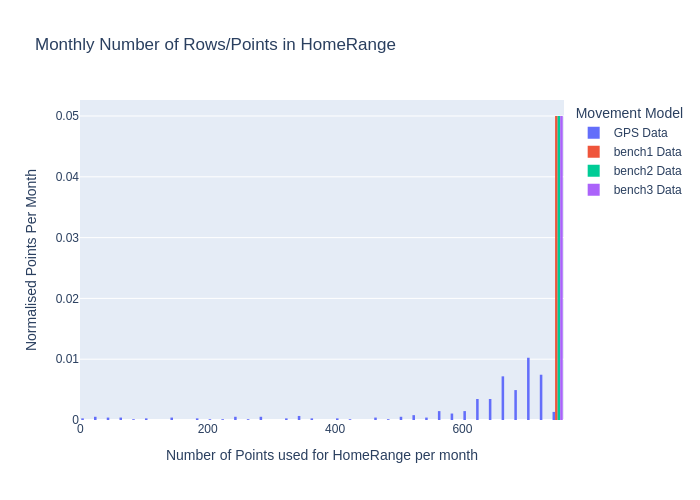

In [14]:
fig = go.Figure() 

 
fig.add_trace(go.Histogram(x=gps_homeranges["samples_in_group"],
                           histnorm='probability density',
                           name = 'GPS Data'))

for filepath in sim_homeranges['filename'].unique():  
    df = sim_homeranges[sim_homeranges['filename'] == filepath]
    
    fig.add_trace(go.Histogram(x=df["samples_in_group"],
                           histnorm='probability density',
                           name = f'{filepath} Data'))

fig.update_layout(
    title=dict(
        text="Monthly Number of Rows/Points in HomeRange"
    ),  
    yaxis=dict(
        title=dict(
            text="Normalised Points Per Month"
        )
    ),
    xaxis=dict(
        title=dict(
            text="Number of Points used for HomeRange per month"
        )
    ),
    legend=dict(
        title=dict(
            text="Movement Model"
        )
    ), 
)
fig.show()

The above figure shows that the simulated data is, obviously, more regular than the GPS data. There are a few GPS devices that have far fewer samples in a given month than expected. These few GPS points would alter the expected monthly home range size. Let's drop all rows that have a points/month that is too low.

In [15]:
# Do Some data filtering

gps_homeranges = gps_homeranges[gps_homeranges['samples_in_group'] > 600]
gps_homeranges = gps_homeranges[gps_homeranges['area'] < 40]


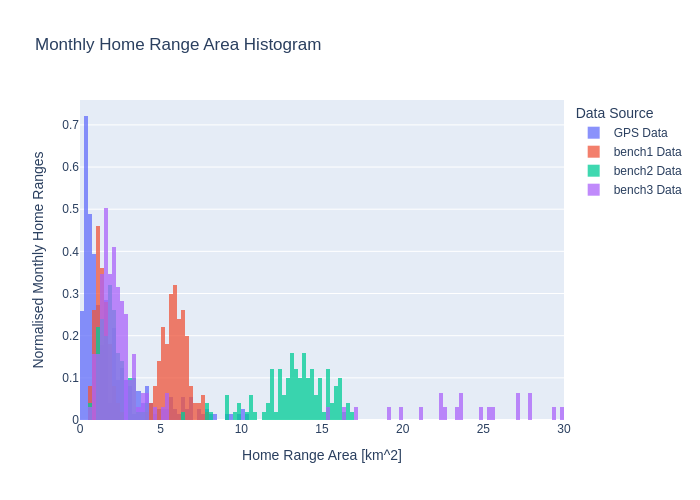

In [16]:
fig = go.Figure() 

 
fig.add_trace(go.Histogram(x=gps_homeranges["area"],
                           histnorm='probability density',
                           name = 'GPS Data'))

for filepath in sim_homeranges['filename'].unique():  
    df = sim_homeranges[sim_homeranges['filename'] == filepath]
    
    fig.add_trace(go.Histogram(x=df["area"],
                           histnorm='probability density',
                           name = f'{filepath} Data'))
fig.update_layout(
    title=dict(
        text="Monthly Home Range Area Histogram"
    ),  
    yaxis=dict(
        title=dict(
            text="Normalised Monthly Home Ranges"
        )
    ),
    xaxis=dict(
        title=dict(
            text="Home Range Area [km^2]"
        )
    ),
    legend=dict(
        title=dict(
            text="Data Source"
        )
    ), 
)
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)

fig.update_traces(xbins=dict( # bins used for histogram
        start=0,
        end=30,
        size=0.25
    ))
fig.show()

The above figure shows that the GPS data home ranges are much smaller than any of the modelled home ranges... Not a good result...

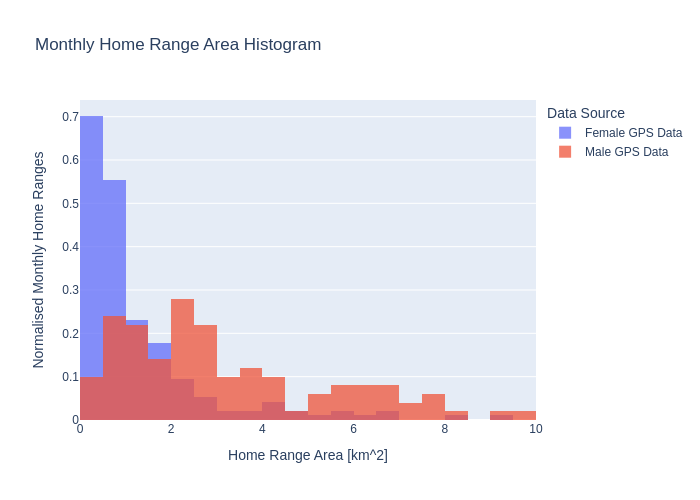

In [17]:
fig = go.Figure() 

fig.add_trace(go.Histogram(x=gps_homeranges[gps_homeranges['sex']=='f']["area"],
                           histnorm='probability density',
                           name = 'Female GPS Data'))

fig.add_trace(go.Histogram(x=gps_homeranges[gps_homeranges['sex']=='m']["area"],
                           histnorm='probability density',
                           name = 'Male GPS Data'))
 
fig.update_layout(
    title=dict(
        text="Monthly Home Range Area Histogram"
    ),  
    yaxis=dict(
        title=dict(
            text="Normalised Monthly Home Ranges"
        )
    ),
    xaxis=dict(
        title=dict(
            text="Home Range Area [km^2]"
        )
    ),
    legend=dict(
        title=dict(
            text="Data Source"
        )
    ), 
)

fig.update_traces(xbins=dict( # bins used for histogram
        start=0,
        end=10,
        size=0.5
    ))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)

fig.show()

The above figure shows that the male/female homeranges in the GPS data is significantly different. It would therefor make sense to model the male/female movement parameters differently.

## Those same step and turn calcs again

Below is the method used to calculate step and turn values from a timeseries of points. It must be known that the values calculated are often for the previous points, so when looking at it with agents mixed up it'll just look plain wrong 

In [18]:
def calc_heading(lon_1, lat_1,
                 lon_2, lat_2,
                 lon_3, lat_3):
    
    '''
    Calculate the turning angle Theta_T to go from t-1 > t > t+1 
    or if Centroid is used as lon/lat_3 then  it should return
    Theta_Ct
    '''    
    dx = lon_2 - lon_1
    dy = lat_2 - lat_1
    angle_radians_1 = np.arctan2(dx, dy) # Compass direction of travel between current_pos and centroid 

    dx = lon_3 - lon_2
    dy = lat_3 - lat_2
    angle_radians_2 = np.arctan2(dx, dy) # Compass direction of travel between current_pos and centroid 
    
    turn_angle = (angle_radians_1 - angle_radians_2) % (2 * np.pi)

    turn_angle = np.mod(turn_angle + np.pi, 2*np.pi) - np.pi
     
    return np.degrees(turn_angle)

def calc_return_home(row):
    heading_to_centroid_recalc =np.arctan2(row['x_centroid'] - row['x'], row['y_centroid'] - row['y'])
    
    if heading_to_centroid_recalc < 0.0:
        heading_to_centroid_recalc +=np.pi*2
    return  np.degrees(heading_to_centroid_recalc)

def calc_step_and_turn(gdf_sim): 
    gdf_sim = gdf_sim.to_crs(sim_projection)
    
    gdf_sim['geometry_prev'] = gdf_sim.groupby('ID')['geometry'].shift(1) 
    gdf_sim['geometry_next'] = gdf_sim.groupby('ID')['geometry'].shift(-1) 
    gdf_sim = gdf_sim.dropna(subset=['geometry_prev','geometry_next']) 
    
    gdf_sim['step_distance_recalc'] = gdf_sim.distance(gdf_sim['geometry_next']) 
    gdf_sim['turn_angle_recalc']  = gdf_sim.apply(lambda row: calc_heading(row['geometry_prev'].x, row['geometry_prev'].y, 
                                                                    row['geometry'].x, row['geometry'].y, 
                                                                    row['geometry_next'].x, row['geometry_next'].y, 
                                                                    ), axis=1) 
    
    
    return gdf_sim

## Look at Movement Params

Similar to the initial data analysis, lets take a look at the step and turn distributions and then some other statistical measures like home range size.

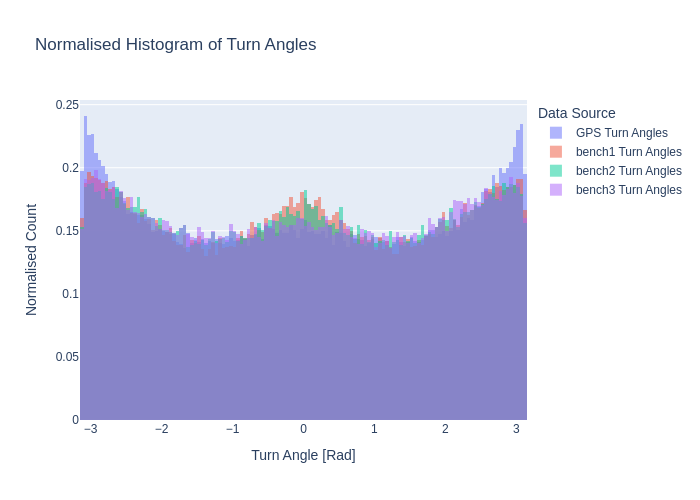

In [19]:

fig = go.Figure() 

fig.add_trace(go.Histogram(x=gdf_gps["turn_angle"].dropna(),
                           histnorm='probability density',
                           name = 'GPS Turn Angles'))

for filepath in gdf_sim['filename'].unique(): 
    df = gdf_sim[gdf_sim['filename'] == filepath]
    df = calc_step_and_turn(df)
    fig.add_trace(go.Histogram(x=np.radians(df["turn"]).dropna(),
                               histnorm='probability density',
                               name = f'{filepath} Turn Angles'))

fig.update_traces(xbins=dict( # bins used for histogram
        start=-3.15,
        end=3.15,
        size=0.05
    ))

fig.update_layout(
    title=dict(
        text="Normalised Histogram of Turn Angles"
    ),  
    yaxis=dict(
        title=dict(
            text="Normalised Count"
        )
    ),
    xaxis=dict(
        title=dict(
            text="Turn Angle [Rad]"
        )
    ),
    legend=dict(
        title=dict(
            text="Data Source"
        )
    ), 
)
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)

fig.show()

In [20]:
gdf_sim['geometry_prev'] = gdf_sim.groupby('ID')['geometry'].shift(1) 
gdf_sim['geometry_next'] = gdf_sim.groupby('ID')['geometry'].shift(-1) 
gdf_sim = gdf_sim.dropna(subset=['geometry_prev','geometry_next']) 


In [21]:
gdf_sim

,timestamp,ID,Is Male,x,y,x_centroid,y_centroid,step,turn,heading_from_prev,turn_to_centroid,heading_to_centroid,Behaviour State,Disease State,filename,geometry,time_group,geometry_prev,geometry_next
200,2000-01-01 02:00:00,1bcef2a7-e66f-480f-9cfb-b9e315bf29e4,True,1.609926e+06,1.971282e+06,1.609646e+06,1.970973e+06,255.928187,-49.881514,20.180221,158.080721,-137.900500,Behaviour_State.NORMAL,Susceptible,bench1,POINT (1609925.828 1971282.388),2000-01,POINT (1609837.54 1971042.171),POINT (1609961.397 1971742.801)
201,2000-01-01 02:00:00,1543e152-c15b-4284-8852-764092dc680f,False,1.604154e+06,1.966006e+06,1.604154e+06,1.965979e+06,26.872841,172.621956,165.646906,345.293546,-179.646640,Behaviour_State.DISPERSE,Infected,bench1,POINT (1604154.334 1966006.176),2000-01,POINT (1604147.673 1966032.21),POINT (1604186.06 1965986.775)
202,2000-01-01 02:00:00,73151ea0-7f5a-4e98-9b56-a101eb02dfac,True,1.599703e+06,1.973875e+06,1.599856e+06,1.973903e+06,137.113130,-78.149659,-118.465570,-198.197233,79.731663,Behaviour_State.DISPERSE,Susceptible,bench1,POINT (1599703.353 1973875.187),2000-01,POINT (1599823.89 1973940.539),POINT (1599714.002 1973856.051)
203,2000-01-01 02:00:00,14f179e3-d522-47c6-b429-19367d239dcc,False,1.597024e+06,1.977335e+06,1.597023e+06,1.977331e+06,6.468624,163.361015,142.554989,313.237693,-170.682704,Behaviour_State.DISPERSE,Susceptible,bench1,POINT (1597023.825 1977334.581),2000-01,POINT (1597019.892 1977339.717),POINT (1597026.745 1977336.826)
204,2000-01-01 02:00:00,c257f5a0-9294-42e1-baed-35f4997d3856,True,1.597799e+06,1.966274e+06,1.597884e+06,1.966395e+06,112.099855,-24.055112,-150.840798,-186.112892,35.272094,Behaviour_State.DISPERSE,Susceptible,bench1,POINT (1597798.812 1966274.038),2000-01,POINT (1597853.432 1966371.931),POINT (1597297.999 1965862.229)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147995,2000-01-31 20:00:00,5728fce7-23fe-4f92-b4d6-15af7d1cba84,True,1.630619e+06,1.962755e+06,1.635150e+06,1.965797e+06,259.251545,-148.868150,-48.962803,-105.083680,56.120877,Behaviour_State.DISPERSE,Infected,bench3,POINT (1630618.788 1962754.867),2000-01,POINT (1630814.337 1962584.655),POINT (1630595.811 1962737.348)
147996,2000-01-31 20:00:00,fc445f0c-81e0-42da-bbe5-bf226717a4a2,True,1.626823e+06,1.964452e+06,1.619037e+06,1.969438e+06,451.823643,-148.739247,31.966297,89.332437,-57.366141,Behaviour_State.NORMAL,Susceptible,bench3,POINT (1626823.206 1964452.427),2000-01,POINT (1626584.001 1964069.118),POINT (1627501.661 1964030.62)
147997,2000-01-31 20:00:00,29eb854b-54bd-4c9d-833d-6c0880a41200,True,1.632898e+06,1.965079e+06,1.636899e+06,1.966341e+06,203.676142,113.389231,25.531103,-46.958029,72.489132,Behaviour_State.DISPERSE,Susceptible,bench3,POINT (1632897.619 1965078.766),2000-01,POINT (1632809.834 1964894.979),POINT (1633022.034 1965014.114)
147998,2000-01-31 20:00:00,4aa9e7ea-f537-48b6-a694-9c3f51cb9912,False,1.626159e+06,1.960133e+06,1.626984e+06,1.962777e+06,16.623068,-136.318090,-56.121470,-73.461489,17.340019,Behaviour_State.DISPERSE,Recovered,bench3,POINT (1626158.735 1960133.372),2000-01,POINT (1626172.536 1960124.105),POINT (1626156.72 1960113.541)


### Note:
There is a spike at 0 degrees turn angle, this happens when the agent slides up against the edge of the grid boundary, the x/y of the grid value get's set to 0 (or max) and resulting turning angle becomes different from model's chosen turning angle (and is also often 0) 

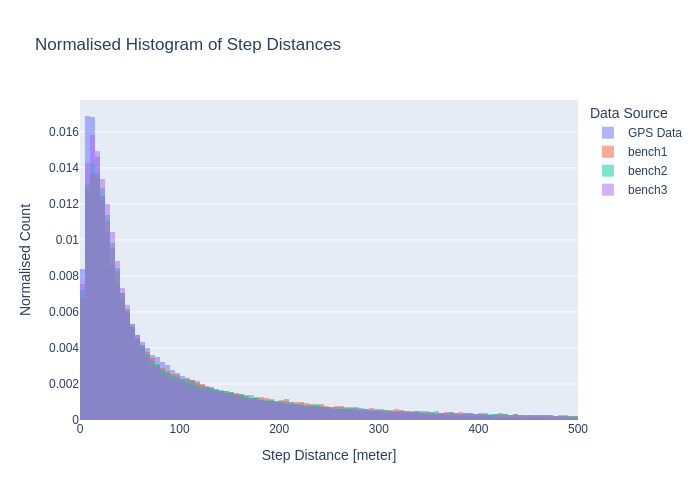

In [22]:
fig = go.Figure() 

fig.add_trace(go.Histogram(x=gdf_gps["step_distance"],
                           histnorm='probability density',
                           name = 'GPS Data'))

for filepath in gdf_sim['filename'].unique(): 
    df = gdf_sim[gdf_sim['filename'] == filepath]
    fig.add_trace(go.Histogram(x=df["step"],
                               histnorm='probability density',
                               name = f'{filepath}'))
     

fig.update_traces(xbins=dict( # bins used for histogram
        start=0,
        end=500,
        size=5
    ))

fig.update_layout(
    title=dict(
        text="Normalised Histogram of Step Distances"
    ),  
    yaxis=dict(
        title=dict(
            text="Normalised Count"
        )
    ),
    xaxis=dict(
        title=dict(
            text="Step Distance [meter]"
        )
    ),
    legend=dict(
        title=dict(
            text="Data Source"
        )
    ), 
)
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)
fig.show()

## HMM Step and Turns vs Behavioural State
Let's compar the step and turn vs behavioural state for a specific run

In [23]:
# hmm_sim = gdf_sim[gdf_sim['filename'] == 'hmm3state']
# # hmm_sim[['filename','turn','turn_angle','step','step_distance']]
# counts, bins = np.histogram(hmm_sim['turn'], bins=100)

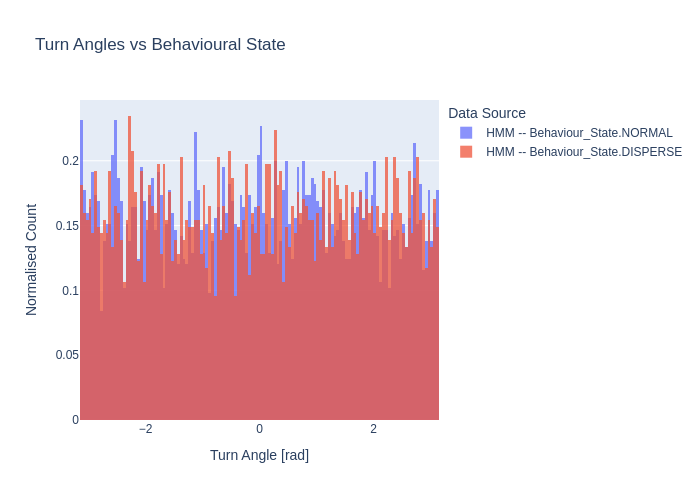

In [24]:
fig = go.Figure() 

# fig.add_trace(go.Histogram(x=gdf_gps["turn_angle"],
#                            histnorm='probability density',
#                            name = 'GPS Data'))

states = gdf_sim['Behaviour State'].unique()
for behaviour_state in states: 
    df = gdf_sim[gdf_sim['Behaviour State'] == behaviour_state]
    fig.add_trace(go.Histogram(x=df["turn"],
                               histnorm='probability density',
                               name = f'HMM -- {behaviour_state}'))
         
 

fig.update_traces(xbins=dict( # bins used for histogram
        start=-3.15,
        end=3.15,
        size=0.05
    ))

fig.update_layout(
    title=dict(
        text="Turn Angles vs Behavioural State"
    ),  
    yaxis=dict(
        title=dict(
            text="Normalised Count"
        )
    ),
    xaxis=dict(
        title=dict(
            text="Turn Angle [rad]"
        )
    ),
    legend=dict(
        title=dict(
            text="Data Source"
        )
    ), 
)
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [25]:
gdf_sim

,timestamp,ID,Is Male,x,y,x_centroid,y_centroid,step,turn,heading_from_prev,turn_to_centroid,heading_to_centroid,Behaviour State,Disease State,filename,geometry,time_group,geometry_prev,geometry_next
200,2000-01-01 02:00:00,1bcef2a7-e66f-480f-9cfb-b9e315bf29e4,True,1.609926e+06,1.971282e+06,1.609646e+06,1.970973e+06,255.928187,-49.881514,20.180221,158.080721,-137.900500,Behaviour_State.NORMAL,Susceptible,bench1,POINT (1609925.828 1971282.388),2000-01,POINT (1609837.54 1971042.171),POINT (1609961.397 1971742.801)
201,2000-01-01 02:00:00,1543e152-c15b-4284-8852-764092dc680f,False,1.604154e+06,1.966006e+06,1.604154e+06,1.965979e+06,26.872841,172.621956,165.646906,345.293546,-179.646640,Behaviour_State.DISPERSE,Infected,bench1,POINT (1604154.334 1966006.176),2000-01,POINT (1604147.673 1966032.21),POINT (1604186.06 1965986.775)
202,2000-01-01 02:00:00,73151ea0-7f5a-4e98-9b56-a101eb02dfac,True,1.599703e+06,1.973875e+06,1.599856e+06,1.973903e+06,137.113130,-78.149659,-118.465570,-198.197233,79.731663,Behaviour_State.DISPERSE,Susceptible,bench1,POINT (1599703.353 1973875.187),2000-01,POINT (1599823.89 1973940.539),POINT (1599714.002 1973856.051)
203,2000-01-01 02:00:00,14f179e3-d522-47c6-b429-19367d239dcc,False,1.597024e+06,1.977335e+06,1.597023e+06,1.977331e+06,6.468624,163.361015,142.554989,313.237693,-170.682704,Behaviour_State.DISPERSE,Susceptible,bench1,POINT (1597023.825 1977334.581),2000-01,POINT (1597019.892 1977339.717),POINT (1597026.745 1977336.826)
204,2000-01-01 02:00:00,c257f5a0-9294-42e1-baed-35f4997d3856,True,1.597799e+06,1.966274e+06,1.597884e+06,1.966395e+06,112.099855,-24.055112,-150.840798,-186.112892,35.272094,Behaviour_State.DISPERSE,Susceptible,bench1,POINT (1597798.812 1966274.038),2000-01,POINT (1597853.432 1966371.931),POINT (1597297.999 1965862.229)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147995,2000-01-31 20:00:00,5728fce7-23fe-4f92-b4d6-15af7d1cba84,True,1.630619e+06,1.962755e+06,1.635150e+06,1.965797e+06,259.251545,-148.868150,-48.962803,-105.083680,56.120877,Behaviour_State.DISPERSE,Infected,bench3,POINT (1630618.788 1962754.867),2000-01,POINT (1630814.337 1962584.655),POINT (1630595.811 1962737.348)
147996,2000-01-31 20:00:00,fc445f0c-81e0-42da-bbe5-bf226717a4a2,True,1.626823e+06,1.964452e+06,1.619037e+06,1.969438e+06,451.823643,-148.739247,31.966297,89.332437,-57.366141,Behaviour_State.NORMAL,Susceptible,bench3,POINT (1626823.206 1964452.427),2000-01,POINT (1626584.001 1964069.118),POINT (1627501.661 1964030.62)
147997,2000-01-31 20:00:00,29eb854b-54bd-4c9d-833d-6c0880a41200,True,1.632898e+06,1.965079e+06,1.636899e+06,1.966341e+06,203.676142,113.389231,25.531103,-46.958029,72.489132,Behaviour_State.DISPERSE,Susceptible,bench3,POINT (1632897.619 1965078.766),2000-01,POINT (1632809.834 1964894.979),POINT (1633022.034 1965014.114)
147998,2000-01-31 20:00:00,4aa9e7ea-f537-48b6-a694-9c3f51cb9912,False,1.626159e+06,1.960133e+06,1.626984e+06,1.962777e+06,16.623068,-136.318090,-56.121470,-73.461489,17.340019,Behaviour_State.DISPERSE,Recovered,bench3,POINT (1626158.735 1960133.372),2000-01,POINT (1626172.536 1960124.105),POINT (1626156.72 1960113.541)


## Timeseries Plots

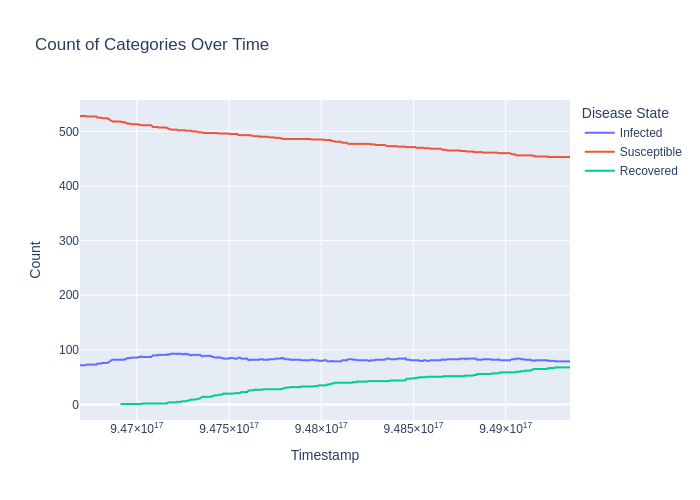

In [26]:

df_grouped = gdf_sim.groupby(['timestamp', 'Disease State']).size().reset_index(name='count')
fig = px.line(df_grouped, x='timestamp', y='count', color='Disease State',
              title='Count of Categories Over Time',
              labels={'timestamp': 'Timestamp', 'count': 'Count', 'category': 'Category'})

fig.show()

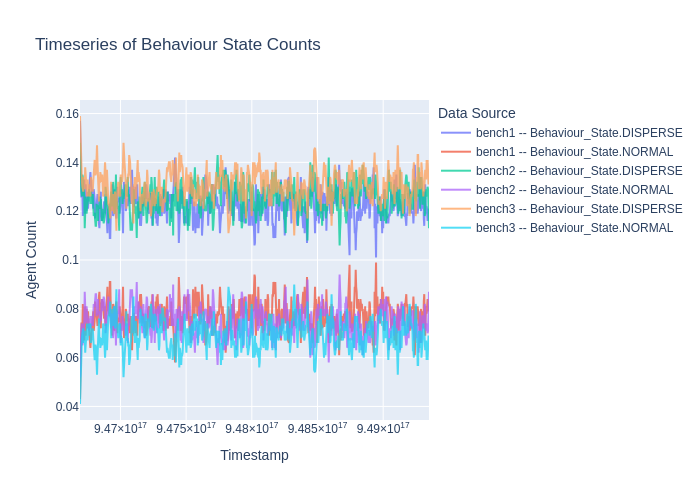

In [27]:
fig = go.Figure()  

for filepath in gdf_sim['filename'].unique(): 
    df = gdf_sim[gdf_sim['filename'] == filepath] 
    df_grouped = df.groupby(['timestamp', 'Behaviour State']).size().reset_index(name='count')
    states = df_grouped['Behaviour State'].unique()
    for behaviour_state in states:
        df_state = df_grouped[df_grouped['Behaviour State'] == behaviour_state] 
        fig.add_trace(go.Scatter(x=df_state["timestamp"],
                                 y=df_state['count']/1000,
                                   name = f'{filepath} -- {behaviour_state}'))
      
fig.update_layout(
    title=dict(
        text="Timeseries of Behaviour State Counts"
    ),  
    yaxis=dict(
        title=dict(
            text="Agent Count"
        )
    ),
    xaxis=dict(
        title=dict(
            text="Timestamp"
        )
    ),
    legend=dict(
        title=dict(
            text="Data Source"
        )
    ), 
)
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()


# Initial distribution:
# --------------------
# [1] 0.1190081 0.4928453 0.3881465

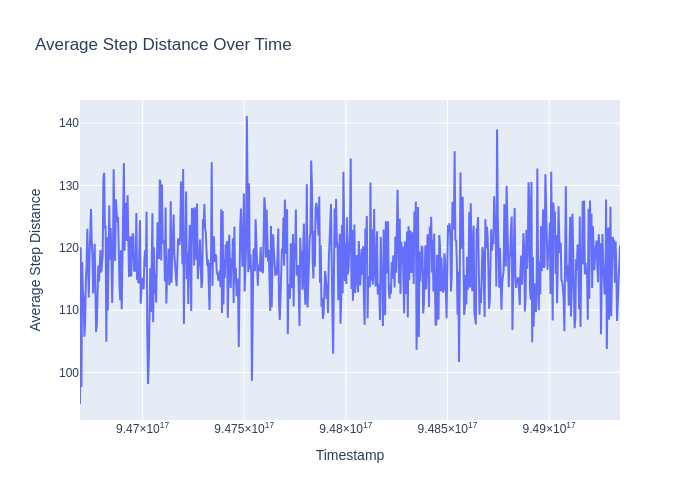

In [28]:

df_grouped = gdf_sim.groupby(['timestamp'])['step'].mean().reset_index(name='count')
fig = px.line(df_grouped, x='timestamp', y='count', 
              # color='Disease State',
              title='Average Step Distance Over Time',
              labels={'timestamp': 'Timestamp', 'count': 'Average Step Distance', 'category': 'Category'})

fig.show()

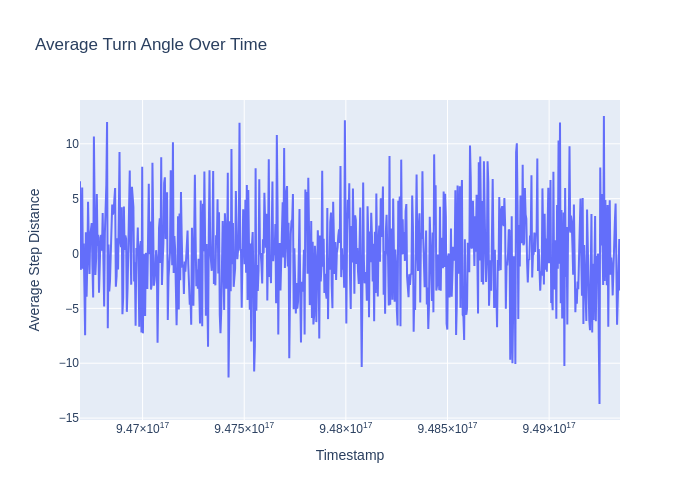

In [29]:

df_grouped = gdf_sim.groupby(['timestamp'])['turn'].mean().reset_index(name='count')
fig = px.line(df_grouped, x='timestamp', y='count', 
              # color='Disease State',
              title='Average Turn Angle Over Time',
              labels={'timestamp': 'Timestamp', 'count': 'Average Step Distance', 'category': 'Category'})

fig.show()

In [30]:
## Export this notebook to HTML and then to pdf
!jupyter nbconvert --no-input --embed-images --to webpdf '04-Post ABM Run.ipynb' 

[NbConvertApp] Converting notebook 04-Post ABM Run.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 100506 bytes to 04-Post ABM Run.pdf


In [31]:
# Convert to GeoDataFrame
gdf_sim = gpd.GeoDataFrame(
    df_sim, 
    geometry=gpd.points_from_xy(df_sim['x'], df_sim['y'], crs=sim_projection)
)
#Reproject to chosen project projection
gdf_sim = gdf_sim.to_crs(chosen_projection) 
gdf_sim['heading_to_centroid_recalculated'] = gdf_sim.apply(lambda row:calc_return_home(row), axis=1)
 
# Save to a GeoPackage file
gdf_sim.to_file(agent_gpkg, layer='agent_location', driver='GPKG')

In [32]:
# Convert to GeoDataFrame
gdf_sim = gpd.GeoDataFrame(
    df_sim, 
    geometry=gpd.points_from_xy(df_sim['x_centroid'], df_sim['y_centroid'], crs=sim_projection)
)
#Reproject to chosen project projection
gdf_sim = gdf_sim.to_crs(chosen_projection)

# Save to a GeoPackage file
gdf_sim.to_file(centroid_gpkg, layer='agent_centroid', driver='GPKG')
 

In [33]:
df_sim['turn_to_centroid_recalc'] = np.degrees(np.mod(np.radians(df_sim['heading_from_prev'] -  df_sim['turn_to_centroid']) +np.pi, 2*np.pi) -np.pi)


# Save to a GeoPackage file
gdf_sim = gpd.GeoDataFrame(
    df_sim, 
    geometry=gpd.points_from_xy(df_sim['x'], df_sim['y'], crs=sim_projection)
)
#Reproject to chosen project projection
gdf_sim = gdf_sim.to_crs(chosen_projection)  
 
# Save to a GeoPackage file
gdf_sim.to_file(agent_gpkg, layer='agent_location', driver='GPKG')

df_sim

,timestamp,ID,Is Male,x,y,x_centroid,y_centroid,step,turn,heading_from_prev,turn_to_centroid,heading_to_centroid,Behaviour State,Disease State,filename,turn_to_centroid_recalc
0,2000-01-01T01:00:00,1bcef2a7-e66f-480f-9cfb-b9e315bf29e4,True,1.609838e+06,1.971042e+06,1.609646e+06,1.970973e+06,203.753732,70.061735,70.061735,180.000000,-109.938265,Behaviour_State.NORMAL,Susceptible,bench1,-109.938265
1,2000-01-01T01:00:00,1543e152-c15b-4284-8852-764092dc680f,False,1.604148e+06,1.966032e+06,1.604154e+06,1.965979e+06,53.483193,-6.975050,-6.975050,-180.000000,173.024950,Behaviour_State.DISPERSE,Infected,bench1,173.024950
2,2000-01-01T01:00:00,73151ea0-7f5a-4e98-9b56-a101eb02dfac,True,1.599824e+06,1.973941e+06,1.599856e+06,1.973903e+06,49.466769,-40.315911,-40.315911,-180.000000,139.684089,Behaviour_State.DISPERSE,Susceptible,bench1,139.684089
3,2000-01-01T01:00:00,14f179e3-d522-47c6-b429-19367d239dcc,False,1.597020e+06,1.977340e+06,1.597023e+06,1.977331e+06,9.390035,-20.806026,-20.806026,-180.000000,159.193974,Behaviour_State.DISPERSE,Susceptible,bench1,159.193974
4,2000-01-01T01:00:00,c257f5a0-9294-42e1-baed-35f4997d3856,True,1.597853e+06,1.966372e+06,1.597884e+06,1.966395e+06,38.750096,-126.785685,-126.785685,-180.000000,53.214315,Behaviour_State.DISPERSE,Susceptible,bench1,53.214315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148195,2000-01-31T21:00:00,5728fce7-23fe-4f92-b4d6-15af7d1cba84,True,1.630596e+06,1.962737e+06,1.635150e+06,1.965797e+06,28.893536,-78.361159,-127.323962,-183.426707,56.102745,Behaviour_State.DISPERSE,Infected,bench3,56.102745
148196,2000-01-31T21:00:00,fc445f0c-81e0-42da-bbe5-bf226717a4a2,True,1.627502e+06,1.964031e+06,1.619037e+06,1.969438e+06,798.888865,89.903598,121.869894,179.296794,-57.426899,Behaviour_State.NORMAL,Susceptible,bench3,-57.426899
148197,2000-01-31T21:00:00,29eb854b-54bd-4c9d-833d-6c0880a41200,True,1.633022e+06,1.965014e+06,1.636899e+06,1.966341e+06,140.211039,91.927174,117.458277,46.354737,71.103540,Behaviour_State.DISPERSE,Susceptible,bench3,71.103540
148198,2000-01-31T21:00:00,4aa9e7ea-f537-48b6-a694-9c3f51cb9912,False,1.626157e+06,1.960114e+06,1.626984e+06,1.962777e+06,19.932934,-118.076039,-174.197509,-191.455639,17.258131,Behaviour_State.DISPERSE,Recovered,bench3,17.258131
